# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [293]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
traffic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [294]:
df = pd.read_csv('/content/Traffic Data.csv')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [295]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [297]:
df.set_index('date_time', inplace=True)

In [298]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [299]:
df=df.sort_index()

In [300]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [302]:
df.shape

(20000, 7)

In [303]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


In [304]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm
2018-09-30 22:00:00,1450.0,282.09,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 23:00:00,954.0,282.12,0.0,0.0,90,Clouds,overcast clouds


In [305]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048395,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


# **Data Preprocessing**
Clean and preprocess the data.

Instructions:

Handle any missing values in the dataset.
If necessary, resample the data to ensure consistent time intervals.
Create any additional features needed, such as lags or moving averages.
Make sure that the dates are sorted correctly.
Do more if needed!

In [306]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [307]:
df = df.fillna(method='ffill')

<ipython-input-307-2c428d02cf67>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [308]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [309]:
df.duplicated().sum()

19

In [310]:
df= df.drop_duplicates()

In [311]:
df.duplicated().sum()

0

In [312]:
df['traffic_volume'].value_counts()

,count
traffic_volume,
353.0,29
344.0,22
340.0,22
373.0,22
358.0,22
...,...
6742.0,1
2011.0,1
2341.0,1


In [313]:
df['temp'].value_counts()

,count
temp,
274.15,93
275.15,65
274.08,63
291.15,58
292.15,52
...,...
279.74,1
269.39,1
277.87,1


In [314]:
df['rain_1h'].value_counts()

,count
rain_1h,
0.00,19268
0.25,269
1.78,68
1.02,29
2.79,17
...,...
0.43,2
0.71,2
0.64,2


In [315]:
df['snow_1h'].value_counts()

,count
snow_1h,
0.0,19981


In [316]:
df['clouds_all'].value_counts()

,count
clouds_all,
90,7672
1,6051
75,2471
40,2020
5,961
20,554
0,100
92,34
8,27


In [317]:
df['weather_main'].value_counts()

,count
weather_main,
Clear,5606
Clouds,5230
Mist,2755
Rain,2244
Snow,1461
Drizzle,992
Haze,672
Thunderstorm,541
Fog,477


In [318]:
df['weather_description'].value_counts()

,count
weather_description,
sky is clear,5506
mist,2755
overcast clouds,1736
broken clouds,1573
scattered clouds,1457
light snow,1246
light rain,1201
moderate rain,747
haze,672


In [319]:
df['weather_main'] = df['weather_main'].replace({"Haze": "Mist", "Fog": "Mist"})

In [320]:
df = pd.get_dummies(df, columns=['weather_main'])

In [321]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_description,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Thunderstorm
date_time,,,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,heavy snow,False,False,False,False,False,False,True,False
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,fog,False,False,False,True,False,False,False,False
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,mist,False,False,False,True,False,False,False,False
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,fog,False,False,False,True,False,False,False,False
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,mist,False,False,False,True,False,False,False,False


In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19981 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   traffic_volume             19981 non-null  float64
 1   temp                       19981 non-null  float64
 2   rain_1h                    19981 non-null  float64
 3   snow_1h                    19981 non-null  float64
 4   clouds_all                 19981 non-null  int64  
 5   weather_description        19981 non-null  object 
 6   weather_main_Clear         19981 non-null  bool   
 7   weather_main_Clouds        19981 non-null  bool   
 8   weather_main_Drizzle       19981 non-null  bool   
 9   weather_main_Mist          19981 non-null  bool   
 10  weather_main_Rain          19981 non-null  bool   
 11  weather_main_Smoke         19981 non-null  bool   
 12  weather_main_Snow          19981 non-null  bool   
 13  weather_mai

In [325]:
df = df.drop(['weather_description'], axis=1)

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19981 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   traffic_volume             19981 non-null  float64
 1   temp                       19981 non-null  float64
 2   rain_1h                    19981 non-null  float64
 3   snow_1h                    19981 non-null  float64
 4   clouds_all                 19981 non-null  int64  
 5   weather_main_Clear         19981 non-null  bool   
 6   weather_main_Clouds        19981 non-null  bool   
 7   weather_main_Drizzle       19981 non-null  bool   
 8   weather_main_Mist          19981 non-null  bool   
 9   weather_main_Rain          19981 non-null  bool   
 10  weather_main_Smoke         19981 non-null  bool   
 11  weather_main_Snow          19981 non-null  bool   
 12  weather_main_Thunderstorm  19981 non-null  bool   
dtypes: bool(8),

# **plot the time series data**

<Axes: xlabel='date_time'>

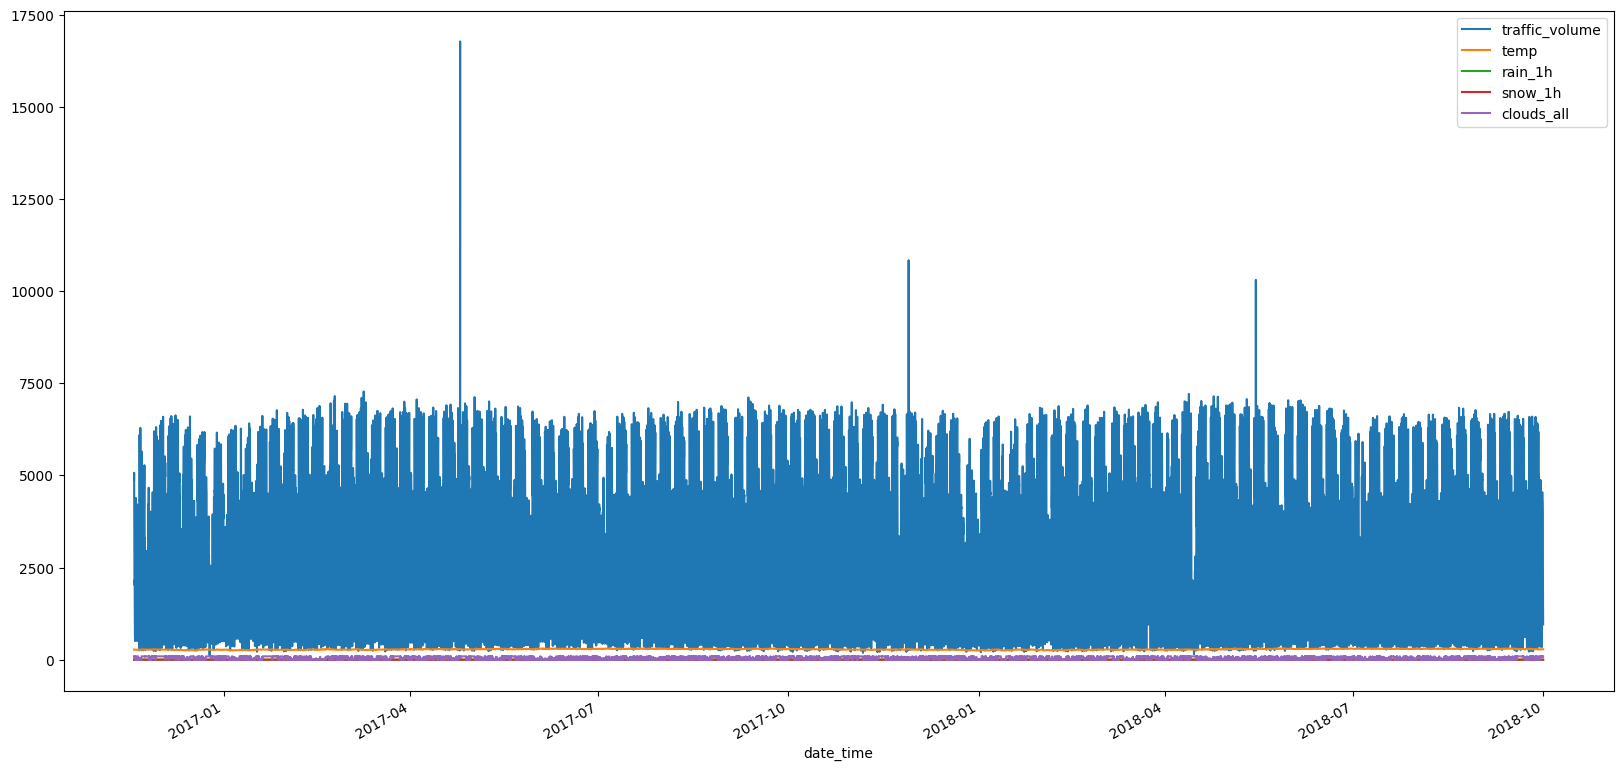

In [327]:
df.plot(figsize=(20,10))

<Axes: xlabel='date_time'>

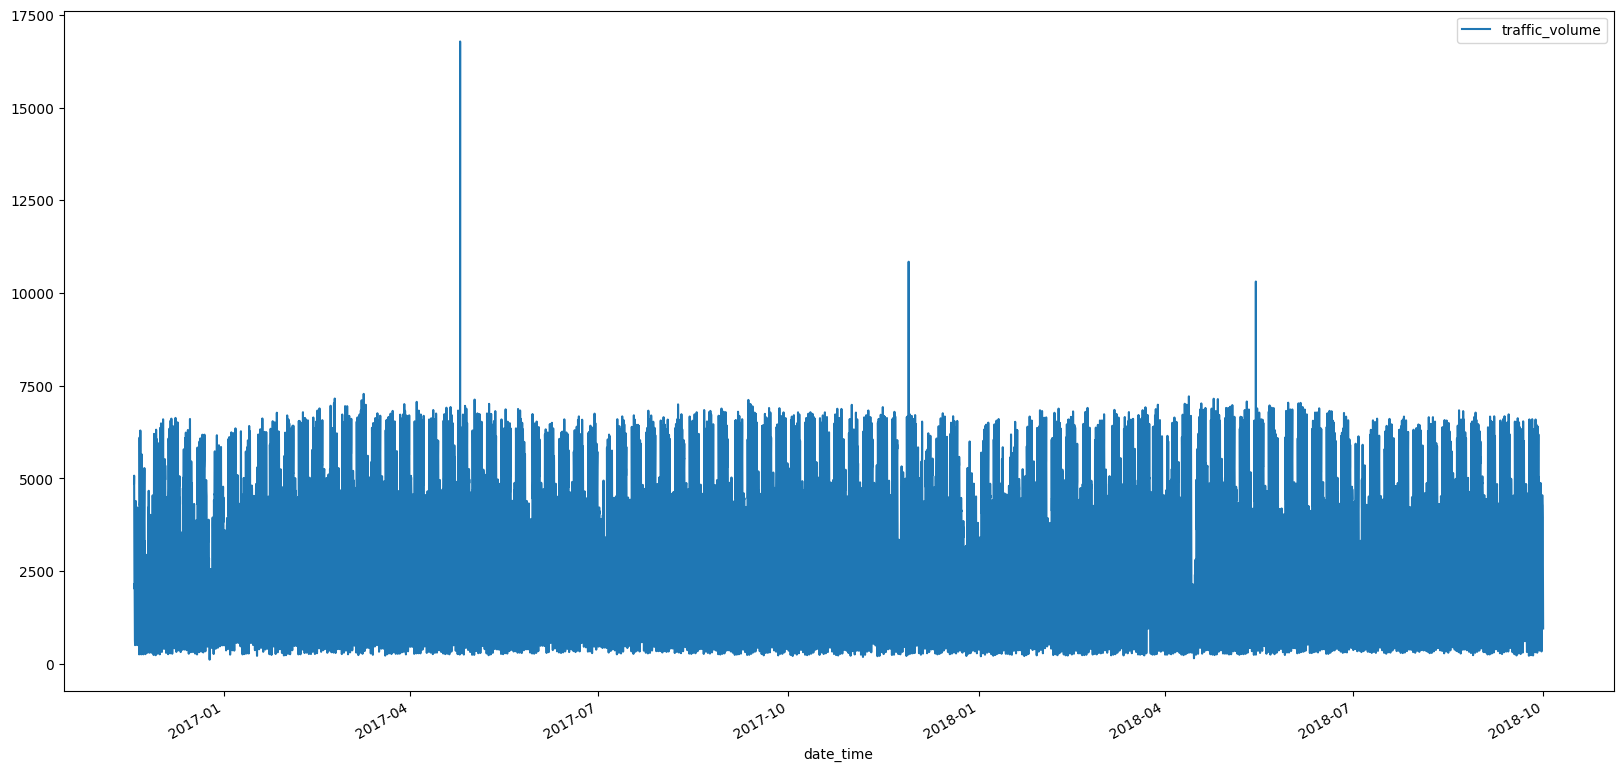

In [328]:
df[['traffic_volume']].plot(figsize=(20,10))

<Axes: xlabel='date_time'>

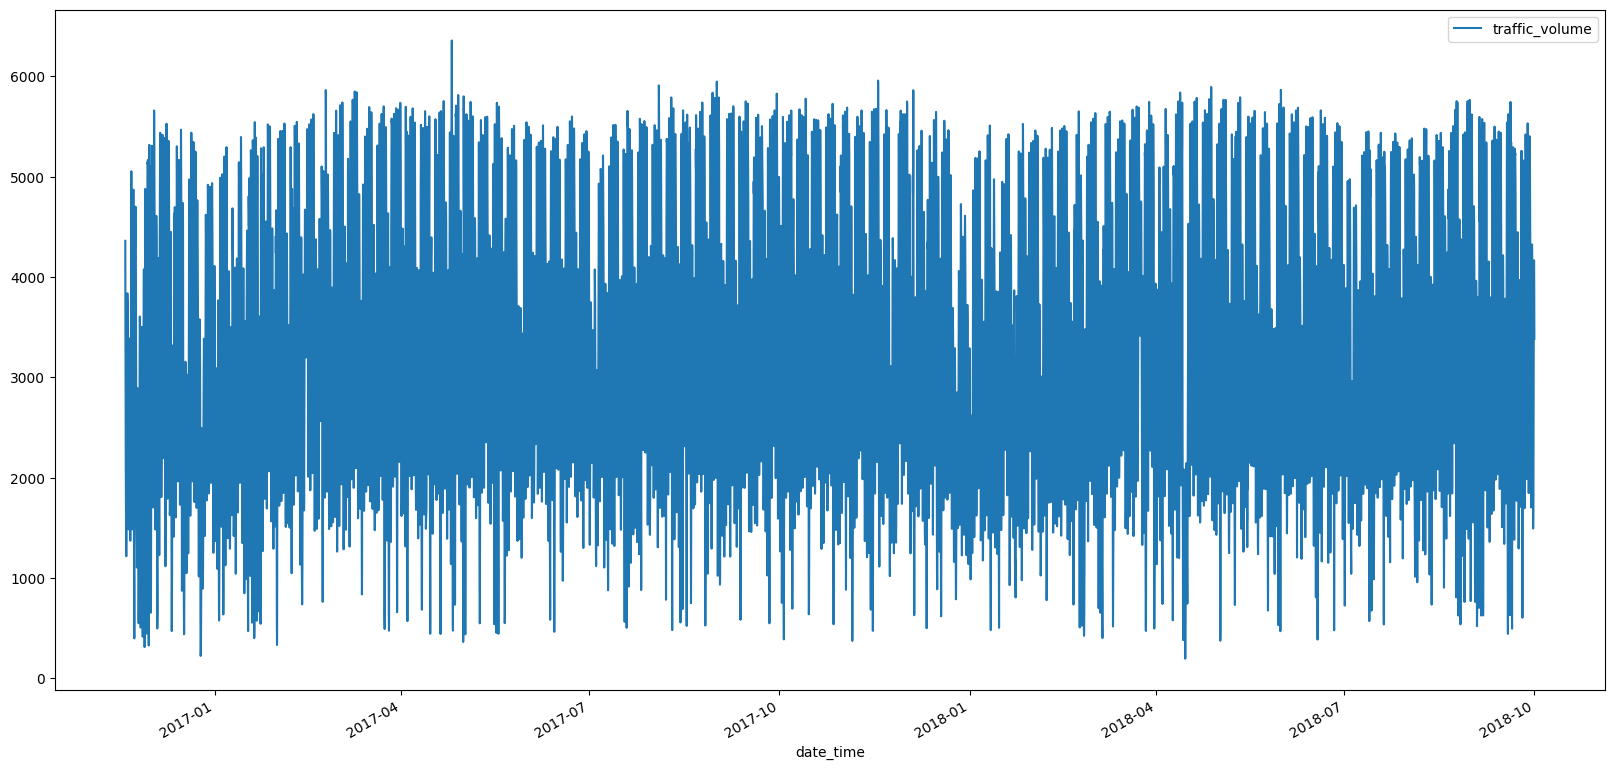

In [329]:
df[['traffic_volume']].rolling(12).mean().plot(figsize=(20,10))

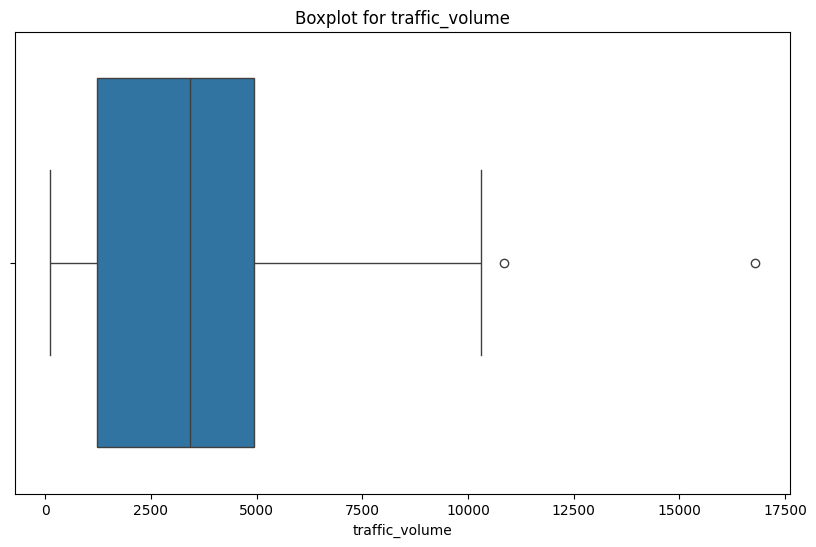

In [330]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['traffic_volume'])
plt.title('Boxplot for traffic_volume')
plt.show()

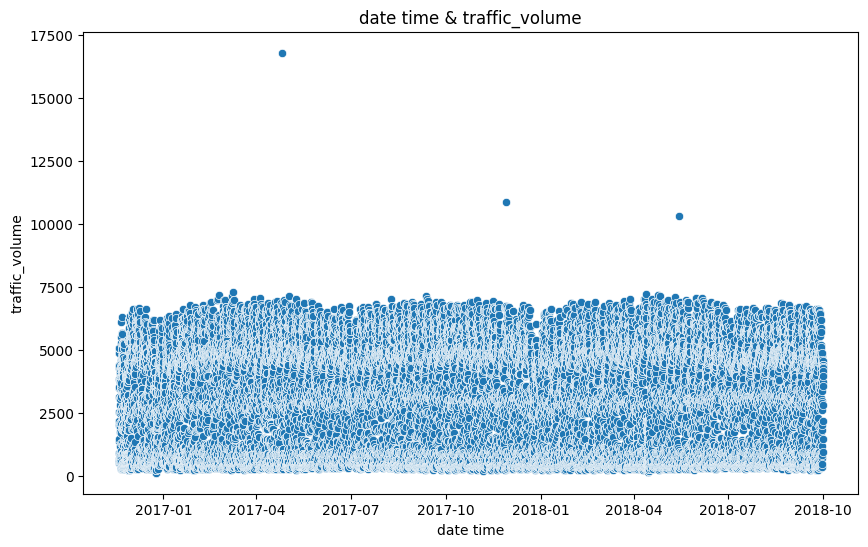

In [331]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.index, y=df['traffic_volume'], data=df)
plt.title('date time & traffic_volume')
plt.xlabel('date time')
plt.ylabel('traffic_volume')
plt.show()

In [332]:
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3 + 1.5 *IQR
df= df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume']<= upper_bound)]

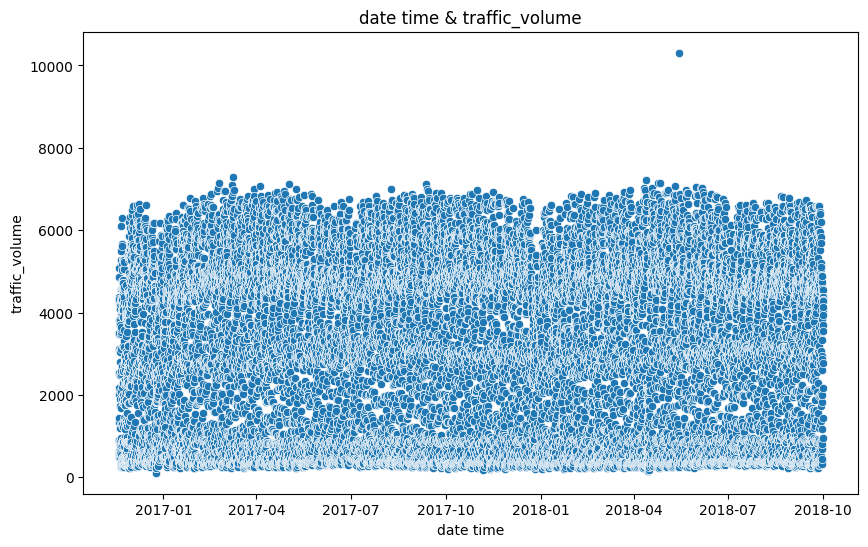

In [333]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.index, y=df['traffic_volume'], data=df)
plt.title('date time & traffic_volume')
plt.xlabel('date time')
plt.ylabel('traffic_volume')
plt.show()

# **Seasonal Decomposition for the target**

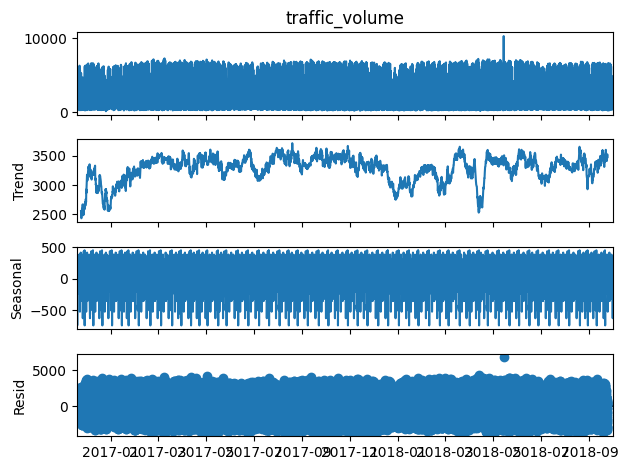

In [334]:
decomposition = seasonal_decompose(df['traffic_volume'],model='additive', period=365)
decomposition.plot()
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


# **Shift Method**

In [335]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

# **Date Features**

In [336]:
df['Day of the week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day of the year'] = df.index.dayofyear

In [337]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Thunderstorm,prev_traffic_volume,Day of the week,Month,Day of the year
date_time,,,,,,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,False,False,False,True,False,NaN,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,False,False,False,True,False,False,False,False,5074.0,4,11,323


In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19979 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   traffic_volume             19979 non-null  float64
 1   temp                       19979 non-null  float64
 2   rain_1h                    19979 non-null  float64
 3   snow_1h                    19979 non-null  float64
 4   clouds_all                 19979 non-null  int64  
 5   weather_main_Clear         19979 non-null  bool   
 6   weather_main_Clouds        19979 non-null  bool   
 7   weather_main_Drizzle       19979 non-null  bool   
 8   weather_main_Mist          19979 non-null  bool   
 9   weather_main_Rain          19979 non-null  bool   
 10  weather_main_Smoke         19979 non-null  bool   
 11  weather_main_Snow          19979 non-null  bool   
 12  weather_main_Thunderstorm  19979 non-null  bool   
 13  prev_traffi

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [339]:
train_size = int(len(df) *0.8)
train = df[:train_size]
test = df[train_size:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [343]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Thunderstorm,prev_traffic_volume,Day of the week,Month,Day of the year
date_time,,,,,,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,False,False,False,True,False,NaN,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,False,False,False,True,False,False,False,False,4872.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,False,False,False,True,False,False,False,False,5074.0,4,11,323


In [379]:
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
columns_to_scale = train.columns
train_scaled[columns_to_scale] =scaler.fit_transform(train[columns_to_scale])
test_scaled[columns_to_scale] =scaler.transform(test[columns_to_scale])

In [380]:
train_scaled.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Thunderstorm,prev_traffic_volume,Day of the week,Month,Day of the year
date_time,,,,,,,,,,,,,,,,,
2016-11-18 15:00:00,0.466752,0.482320,0.0,0.0,0.978261,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.666667,0.909091,0.882192
2016-11-18 15:00:00,0.466752,0.482320,0.0,0.0,0.978261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.466752,0.666667,0.909091,0.882192
2016-11-18 15:00:00,0.466752,0.482320,0.0,0.0,0.978261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.466752,0.666667,0.909091,0.882192
2016-11-18 16:00:00,0.486563,0.478548,0.0,0.0,0.978261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.466752,0.666667,0.909091,0.882192
2016-11-18 16:00:00,0.486563,0.478548,0.0,0.0,0.978261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.486563,0.666667,0.909091,0.882192


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [381]:
train_target =train_scaled['traffic_volume']
test_target= test_scaled['traffic_volume']

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [382]:
tes_model = ExponentialSmoothing(train_target, trend='add', seasonal='add', seasonal_periods=12).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [383]:
tes_pred = tes_model.forecast(steps=len(test_target))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [396]:
tes_mae = mean_absolute_error(test_target, tes_pred)
tes_mse = mean_squared_error(test_target, tes_pred)
tes_rmse = np.sqrt(tes_mse)
tes_mape = mean_absolute_percentage_error(test_target, tes_pred)

print(f'ARIMA model')
print(f'MAE: {tes_mae}')
print(f'MSE: {tes_mse}')
print(f'RMSE: {tes_rmse}')
print(f'MAPE: {tes_mape}')

ARIMA model
MAE: 0.3301670547376741
MSE: 0.1463506724562185
RMSE: 0.38255806416309995
MAPE: 1.1473984581899839


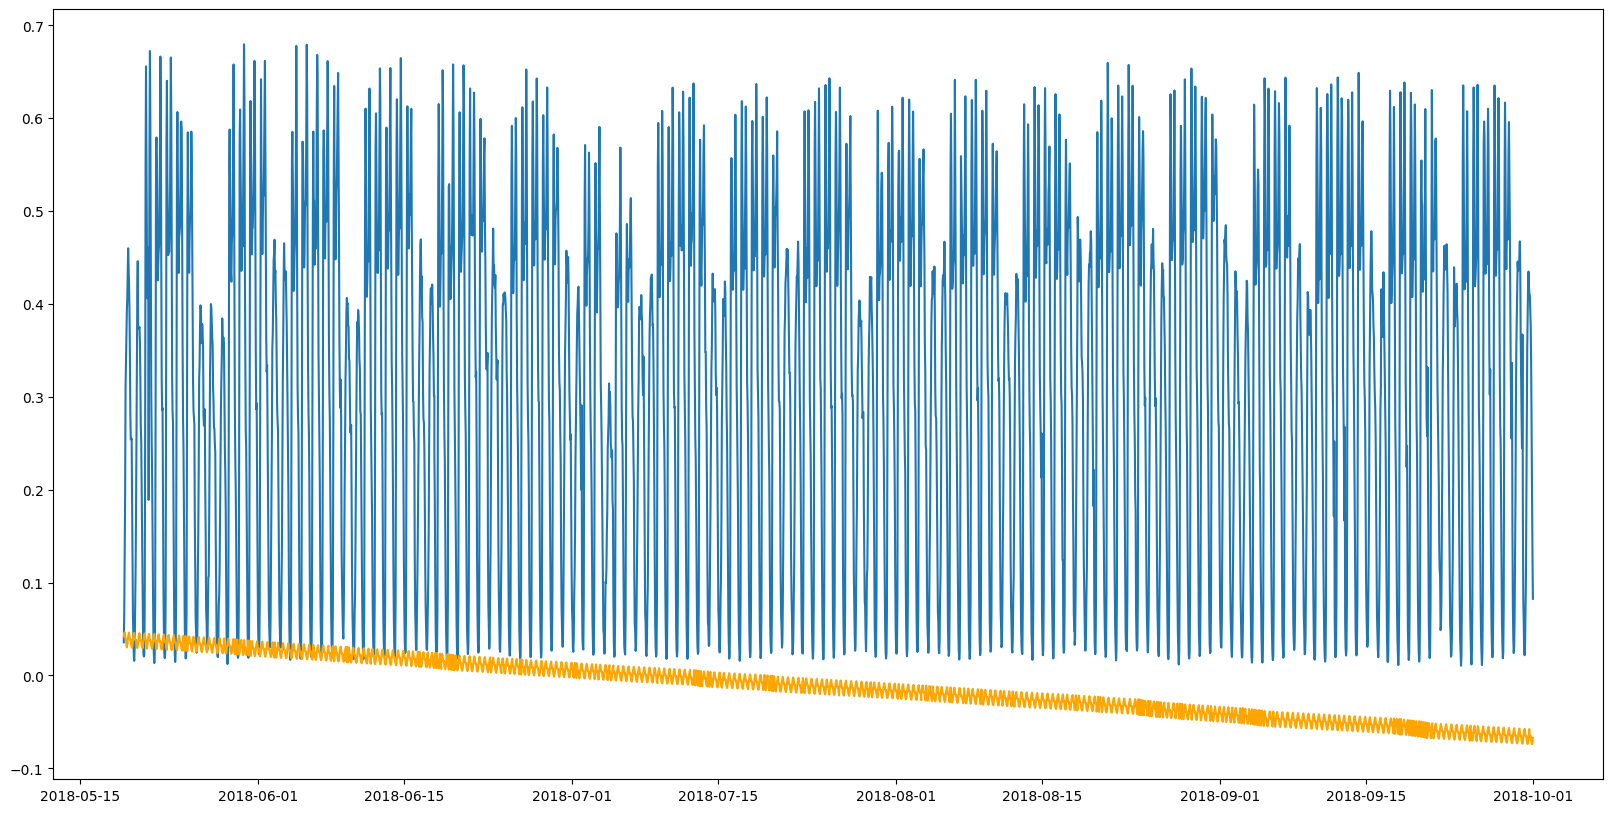

In [397]:
plt.figure(figsize=(20,10))
plt.plot(test_scaled.index, test_target, label= 'Actual')
plt.plot(test_scaled.index, tes_pred, label= 'predicated', color='orange')

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

# **LSTM**

In [406]:
def create_sequences(data, seq_length):
   X, y =[], []
   for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [407]:
seq_length = 10
X_train, y_train = create_sequences(train_scaled['traffic_volume'].values, seq_length)
X_test, y_test = create_sequences(test_scaled['traffic_volume'].values, seq_length)

In [408]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [409]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(seq_length ,1)))
model.add(Dense(1))
model.compile(optimizer='adam' , loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0152 - val_loss: 0.0570
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0136 - val_loss: 0.0547
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0121 - val_loss: 0.0523
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0107 - val_loss: 0.0500
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0093 - val_loss: 0.0477
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0080 - val_loss: 0.0454
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0066 - val_loss: 0.0431
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0054 - val_loss: 0.0409
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0042 - val_loss: 0.0388
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0032 - val_loss: 0.0367


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [410]:
lstm_pred = model.predict(X_train)
lstm_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [422]:
trainPredict = scaler.inverse_transform(train_scaled)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(lstm_pred)
y_test = scaler.inverse_transform([y_test])

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,17)

In [399]:
lstm_mae = mean_absolute_error(y_test, lstm_pred)
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)

print(f'LSTM model')
print(f'MAE: {lstm_mae}')
print(f'MSE: {lstm_mse}')
print(f'RMSE: {lstm_rmse}')
print(f'MAPE: {lstm_mape}')

LSTM model
MAE: 0.40229560588893876
MSE: 0.16184175451754834
RMSE: 0.40229560588893876
MAPE: 0.9893405686549975


In [418]:
y_test = y_test.reshape(-1)
lstm_pred = lstm_pred.reshape(-1)

ValueError: x and y must have same first dimension, but have shapes (3986,) and (1,)

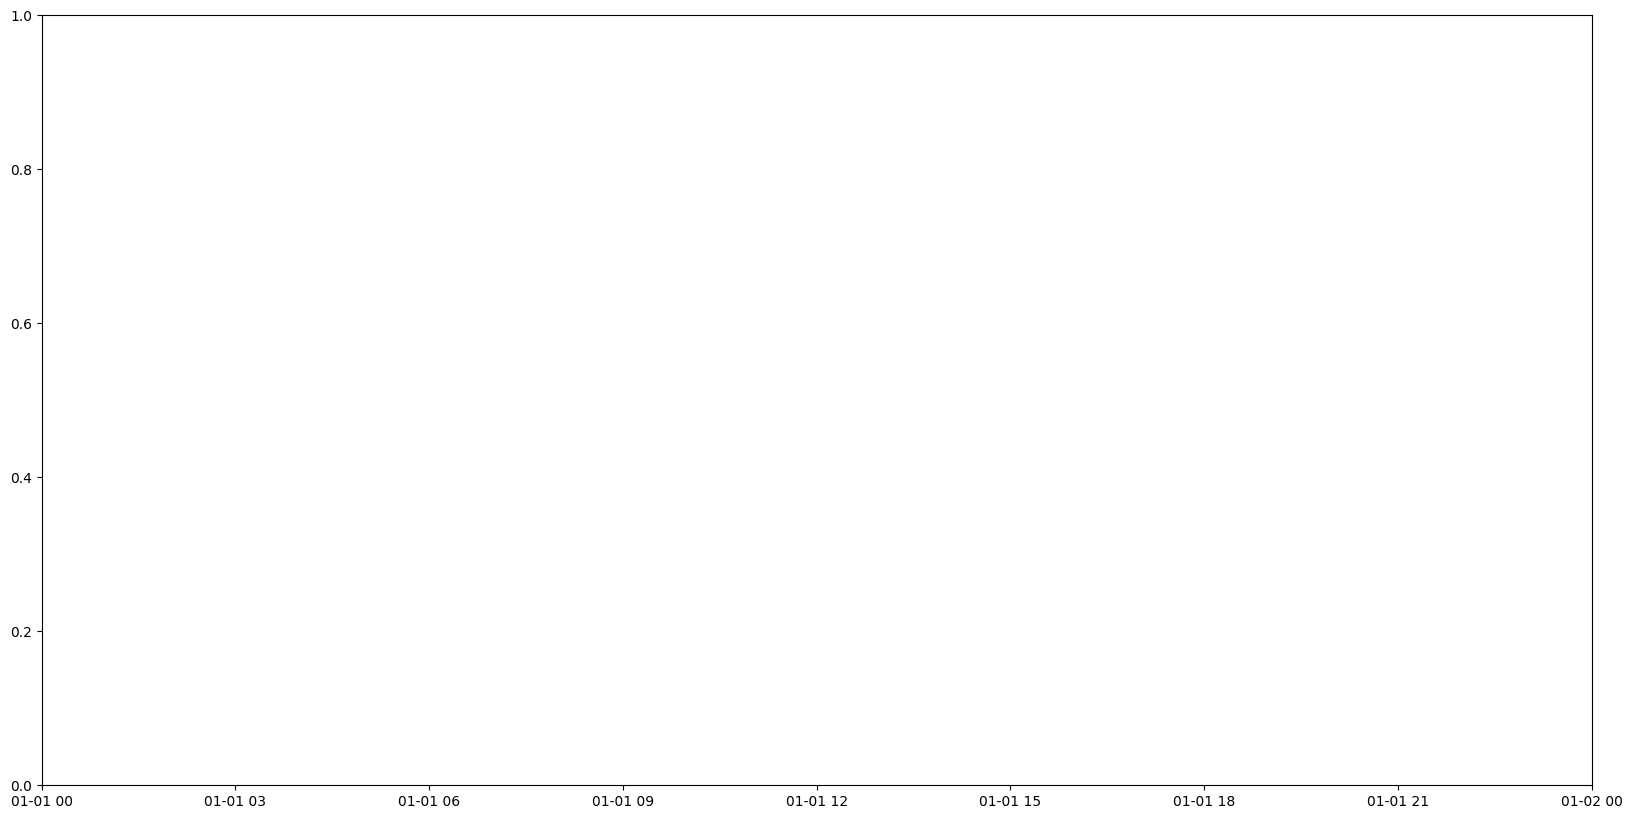

In [420]:
plt.figure(figsize=(20,10))
plt.plot(test_scaled.index[seq_length:], y_test, label= 'Actual')
plt.plot(test_scaled.index[seq_length:], lstm_pred, label= 'predicated', color='orange')

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?  I used method='ffill to fill the missing values ​​with the previous values.                                                        
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model. 3 columns were built and extracted from the date time.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: